# Introduction


In this assignment, you will practice building and training Convolutional Neural Networks with Pytorch to solve computer vision tasks.  This assignment includes two sections, each involving different tasks:

(1) Image Classification. Predict image-level category labels on two historically notable image datasets: **CIFAR-10** and **MNIST**.

(2) Image Segmentation. Predict pixel-wise classification (semantic segmentation) on synthetic input images formed by superimposing MNIST images on top of CIFAR images.

You will design your own models in each section and build the entire training/testing pipeline with PyTorch. 
PyTorch provides optimized implementations of the building blocks and additional utilities, both of which will be necessary for experiments on real datasets. It is highly recommended to read the official [documentation](https://pytorch.org/docs/stable/index.html) and [examples](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) before starting your implementation. There are some APIs that you'll find useful:
[Layers](http://pytorch.org/docs/stable/nn.html),
[Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
[Loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions),
[Optimizers](http://pytorch.org/docs/stable/optim.html)

It is highly recommended to use Google Colab and run the notebook on a GPU node. Check https://colab.research.google.com/ and look for tutorials online. To use a GPU go to Runtime -> Change runtime type and select GPU. 






# (1) Image Classification

In this section, you will design and train an image classification network, which takes images as input and outputs vectors whose length equals the number of possible categories on **MNIST** and **CIFAR-10** datasets. 

You can design your models by borrowing ideas from recent architectures, e.g., ResNet, but you may not simply copy an entire existing model. 

For image classification, you can use a built-in dataset provided by [torchvision](https://pytorch.org/vision/stable/index.html), a PyTorch official extension for image tasks. 

To finish this section step by step, you need to:

* Prepare data by building a dataset and dataloader. (with [torchvision](https://pytorch.org/vision/stable/index.html))

* Implement training code (6 points) & testing code (6 points), including model saving and loading.

* Construct a model (12 points) and choose an optimizer (3 points).

* Describe what you did, any additional features you implemented, and/or any graphs you made in training and evaluating your network. Also report final test accuracy @100 epochs in a writeup: hw3.pdf (3 points)

In [7]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.transforms as T

# Check GPU availability
assert torch.has_mps == True, "PyTorch not working on GPU"

## Data Preparation:

Setup a Dataset for training and testing.

Datasets load single training examples one a time, so we practically wrap each Dataset in a DataLoader, which loads a data batch in parallel.

We provide an example for setting up a training set for MNIST, and you should complete the rest. 

In [8]:
mnist_data_train = torchvision.datasets.MNIST('./data', train = True, transform = T.ToTensor())
cfar10_data_train = torchvision.datasets.CIFAR10('./data', train = True, transform = T.ToTensor())

mnist_data_test = torchvision.datasets.MNIST('./data', train = False, transform = T.ToTensor())
cfar10_data_test = torchvision.datasets.CIFAR10('./data', train = False, transform = T.ToTensor())
##########################################################################
# TODO: YOUR CODE HERE
# (1) Instantiate the train/test split for CIFAR-10 and MNIST
# (2) You can adjust the batch size and number of works for better efficiency
# (3) Remember to set shuffle=True for all training set 
##########################################################################
def get_train_test_dataloaders(train_data, test_data, batch_size, shuffle, num_workers, drop_last):

    # drop last batch to prevent batch size of 1 in MINST dataset
    train_loader = DataLoader(dataset = train_data, batch_size = batch_size,
                              shuffle = shuffle, num_workers = num_workers, drop_last = drop_last)
    
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size,
                              shuffle = shuffle, num_workers = num_workers)
    
    return train_loader, test_loader

batch_size = 128
shuffle = True
num_workers = 0 # set to 0 to allow debugging

train_mnist_loader, test_minst_loader = get_train_test_dataloaders(mnist_data_train, mnist_data_test, \
                                        batch_size, shuffle, num_workers, True)

train_cfar10_loader, test_cfar10_loader = get_train_test_dataloaders(cfar10_data_train, cfar10_data_test, \
                                        batch_size, shuffle, num_workers, False)


In [9]:
len(train_mnist_loader)

468

In [10]:
cfar10_data_train.data.shape

(50000, 32, 32, 3)

In [11]:
len(test_minst_loader)

79

In [12]:
len(train_cfar10_loader)

391

In [13]:
len(test_cfar10_loader)

79

## Design/choose your own model structure (12 points) and optimizer (3 points).
You might want to adjust the following configurations for better performance:

(1) Network architecture:
- You can borrow some ideas from existing CNN designs, e.g., ResNet where
the input from the previous layer is added to the output
https://arxiv.org/abs/1512.03385
- Note: Do not **directly copy** an entire existing network design.

(2) Architecture hyperparameters:
- Filter size, number of filters, and number of layers (depth). Make careful choices to tradeoff computational efficiency and accuracy.
- Pooling vs. Strided Convolution
- Batch normalization
- Choice of non-linear activation

(3) Choice of optimizer (e.g., SGD, Adam, Adagrad, RMSprop) and associated hyperparameters (e.g., learning rate, momentum).

In [14]:
#Basic model, feel free to customize the layout to fit your model design.
import torch.nn as nn
import torch.nn.functional as F

##########################################################################
# TODO: YOUR CODE HERE
# (1) Design the model for MNIST
# (2) Design the model for CIFAR-10
##########################################################################

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, rep):
        super().__init__()
        kernel_size = 3
        padding = kernel_size // 2

        layers = []
        # First layer downsamples, others do not 
        for i in range(rep):
            if i == 0:
                layers.append(nn.Conv2d(in_ch, out_ch, kernel_size, 1, padding))
            else:
                layers.append(nn.Conv2d(out_ch, out_ch, kernel_size, 1, padding))
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.ReLU(inplace=True))
        
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class myNet(nn.Module):
    def __init__(self, img_channel, img_w, n_classes, nconvblocks):
        super(myNet, self).__init__()
        # img_channel: # channels in image
        # img_w: width of image in pixels
        # n_classes: # classes to classify
        # nconvblocks: # blocks of 2xconvolution + relu + pool in model
        # Set up your own CNN.
        channels = [img_channel]
        out_w = img_w
        self.nconvblocks = nconvblocks
        for _ in range(self.nconvblocks):
            channels.append(channels[-1] * 3)
            out_w = out_w // 2

        # Use nn.ModuleList to make it work over GPU
        nc = len(channels)
        self.conv1 = nn.ModuleList([ConvBlock(channels[i], channels[i+1], 1) for i in range(nc - 1)])
        self.ress = nn.ModuleList([ConvBlock(channels[i], channels[i], 2) for i in range(1,nc)])
        self.conv2 = nn.ModuleList([ConvBlock(channels[i], channels[i], 1) for i in range(1, nc)])
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # flatten
        fc_layers = []
        fc_layers.append(nn.Flatten(start_dim=1)) # flatten after batch dim
        
        # prep fully connected layer sizes 
        lin_size = out_w * out_w * channels[-1]
        l = lin_size
        lin_sizes = []
        while l > n_classes:
            lin_sizes.append(l)
            l = l // 2
        # fully connected layers
        n_flat = len(lin_sizes)
        for i in range(n_flat - 1):
            fc_layers.append(nn.Linear(lin_sizes[i], lin_sizes[i + 1]))
            fc_layers.append(nn.BatchNorm1d(lin_sizes[i + 1]))
            fc_layers.append(nn.ReLU(inplace=True))
        # final output layer
        fc_layers.append(nn.Linear(lin_sizes[i + 1], n_classes))
        
        self.fc_layers = nn.Sequential(*fc_layers)
    
    def forward(self, x):
        # forward pass
        for i in range(self.nconvblocks):
            x = self.conv1[i](x)
            x = self.ress[i](x) + x
            x = self.conv2[i](x)
            x = self.pool(x)

        x = self.fc_layers(x)
        return x

class CIFAR10_models(myNet):
    def __init__(self, img_channel, img_w, n_classes):
        nconvblocks = 4
        super(CIFAR10_models, self).__init__(img_channel, img_w, n_classes, nconvblocks)


class MNIST_models(myNet):
    def __init__(self, img_channel, img_w, n_classes):
        nconvblocks = 1
        super(MNIST_models, self).__init__(img_channel, img_w, n_classes, nconvblocks)

## Training (6 points)

Train a model on the given dataset using the PyTorch Module API.

Inputs:
- loader_train: The loader from which train samples will be drawn from.
- loader_test: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to train.
- optimizer: An Optimizer object we will use to train the model.
- epochs: (Optional) A Python integer giving the number of epochs to train for.

Returns: Nothing, but prints model accuracies during training.

In [15]:
def train(loader_train, loader_test, model, optimizer, device, epochs=100):
    model = model.to(device)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    epochs_no_improve = 0 # if you don't improve for 5 epochs, stop model
    for e in range(epochs):
        model.train()
        epoch_loss = 0
        num_samples = 0
        num_correct = 0

        for idx, (x, y) in enumerate(loader_train):
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move data to GPU
            # (2) forward and get loss
            # (3) zero out all of the gradients for the variables which the optimizer
            # will update.
            # (4) the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            # (5) update the parameters of the model using the gradients
            # computed by the backwards pass.
            ##########################################################################
            # move data to GPU 
            x = x.to(device)
            y = y.to(device) 
            
            y_hat = model(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y)
            optimizer.zero_grad() # set gradients to 0

            loss.backward() # compute derivatives
            optimizer.step() # update parameters  

            # compute metrics
            epoch_loss += loss.item() * x.shape[0]
            _, y_tilde = torch.max(y_hat, 1) # predicted label
            num_samples += y.size(0)
            num_correct += (y_tilde == y).sum()


            if idx % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, idx, loss.item()))
        
        # Compute loss/accuracy metrics 
        train_acc.append((100 * num_correct / num_samples).tolist())
        train_loss.append(epoch_loss / len(loader_train.dataset))

        vl, va = test(loader_test, model, device)
        val_loss.append(vl)
        val_acc.append(va)

        # Implement early stopping
        if vl > min(val_loss) * 1.1:
            epochs_no_improve += 1
            if epochs_no_improve > 5:
                break
        else:
            epochs_no_improve = 0
        
    return train_loss, val_loss, train_acc, val_acc

## Testing (6 points)
Test a model using the PyTorch Module API.

Inputs:
- loader: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to test.

Returns: Nothing, but prints model accuracies during training.

In [16]:
def test(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode
    loss = 0
    with torch.no_grad():
        for x, y in loader:
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move to GPU
            # (2) forward and calculate scores and predictions
            # (2) accumulate num_correct and num_samples
            ##########################################################################
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss += torch.nn.functional.cross_entropy(y_hat, y).item() * x.shape[0]
            _, y_tilde = torch.max(y_hat, 1) # predicted label
            num_samples += y.size(0)
            num_correct += (y_tilde == y).sum()
        
        # Print accuracy
        val_acc = 100 * num_correct / num_samples
        print('Eval %d / %d correct (%.2f)' % (num_correct, num_samples, val_acc))
        # Validation loss
        val_loss = loss / len(loader.dataset)
        return val_loss, val_acc.tolist()

Describe your design details in the writeup hw3.pdf. (3 points)

Finish your model and optimizer below.

In [17]:
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

def plot_train_val(train, val, title, ylabel):
    assert len(train) == len(val)
    epochs = list(range(len(train)))
    plt.plot(epochs, train, label = "Train")
    plt.plot(epochs, val, label = "Test")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [18]:
device = torch.device("mps") # set GPU device

# Model parameters
lr = 0.002

In [19]:
# Train CFAR-10 Model
img_channel = cfar10_data_train.data.shape[-1]
img_w = cfar10_data_train.data.shape[-2]
n_classes = len(cfar10_data_train.classes)

model = CIFAR10_models(img_channel, img_w, n_classes)
optimizer = optim.Adam(model.parameters(), lr, (0.9, 0.999))
train_loss, val_loss, train_acc, val_acc = train(train_cfar10_loader, \
                                test_cfar10_loader, model, optimizer, device, epochs=100)

# Save model
torch.save(model.state_dict(),"CFAR10_classify_mdl.pt")
dummy_input = next(iter(test_cfar10_loader))[0]
torch.onnx.export(model.cpu(), dummy_input, "CFAR10_classify_mdl.onnx", input_names=["Input image"], output_names=["Classification"])

KeyboardInterrupt: 

In [25]:
# Load saved CFAR-10 CNN
img_channel = cfar10_data_train.data.shape[-1]
img_w = cfar10_data_train.data.shape[-2]
n_classes = len(cfar10_data_train.classes)

model = CIFAR10_models(img_channel, img_w, n_classes)
model.load_state_dict(torch.load("CFAR10_classify_mdl.pt"))
test(test_cfar10_loader, model, torch.device("cpu"))

Eval 7982 / 10000 correct (79.82)


(0.7116369375228881, 79.81999969482422)

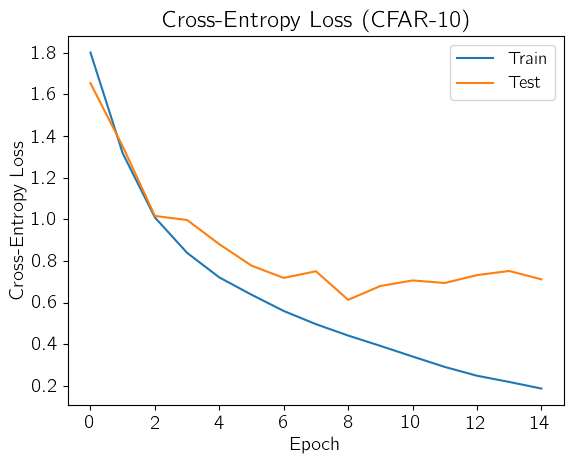

In [26]:
plot_train_val(train_loss, val_loss, "Cross-Entropy Loss (CFAR-10)","Cross-Entropy Loss")

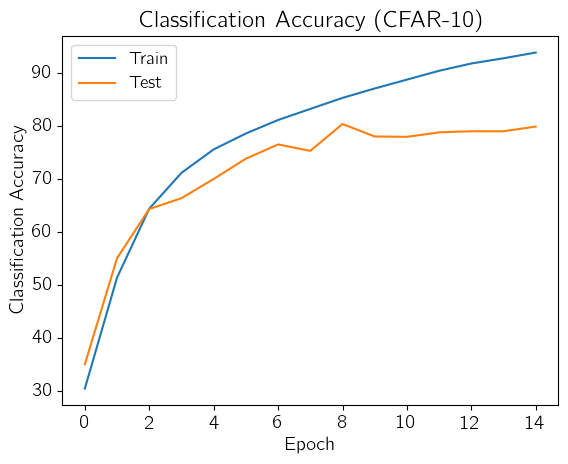

In [27]:
plot_train_val(train_acc, val_acc, "Classification Accuracy (CFAR-10)","Classification Accuracy")

In [28]:
# Train MINST Model
img_channel = 1
img_w = mnist_data_train.data.shape[-1]
n_classes = len(mnist_data_train.classes)
model = MNIST_models(img_channel, img_w, n_classes)
optimizer = optim.Adam(model.parameters(), lr)
train_loss, val_loss, train_acc, val_acc = train(train_mnist_loader, \
                                test_minst_loader, model, optimizer, device, epochs=100)

# Save model
torch.save(model.state_dict(),"MINST_classify_mdl.pt")
dummy_input = next(iter(train_mnist_loader))[0]
torch.onnx.export(model.cpu(), dummy_input, "MINST_classify_mdl.onnx", input_names=["Input image"], output_names=["Classification"])

Epoch 0, Iteration 0, loss = 2.3946
Epoch 0, Iteration 100, loss = 0.4167
Epoch 0, Iteration 200, loss = 0.1341
Epoch 0, Iteration 300, loss = 0.2308
Epoch 0, Iteration 400, loss = 0.0922
Eval 9777 / 10000 correct (97.77)
Epoch 1, Iteration 0, loss = 0.1278
Epoch 1, Iteration 100, loss = 0.0631
Epoch 1, Iteration 200, loss = 0.0750
Epoch 1, Iteration 300, loss = 0.0318
Epoch 1, Iteration 400, loss = 0.0991
Eval 9859 / 10000 correct (98.59)
Epoch 2, Iteration 0, loss = 0.0790
Epoch 2, Iteration 100, loss = 0.0432
Epoch 2, Iteration 200, loss = 0.0630
Epoch 2, Iteration 300, loss = 0.0395
Epoch 2, Iteration 400, loss = 0.0746
Eval 9888 / 10000 correct (98.88)
Epoch 3, Iteration 0, loss = 0.0366
Epoch 3, Iteration 100, loss = 0.0470
Epoch 3, Iteration 200, loss = 0.0187
Epoch 3, Iteration 300, loss = 0.0713
Epoch 3, Iteration 400, loss = 0.0100
Eval 9893 / 10000 correct (98.93)
Epoch 4, Iteration 0, loss = 0.0195
Epoch 4, Iteration 100, loss = 0.0547
Epoch 4, Iteration 200, loss = 0.0748


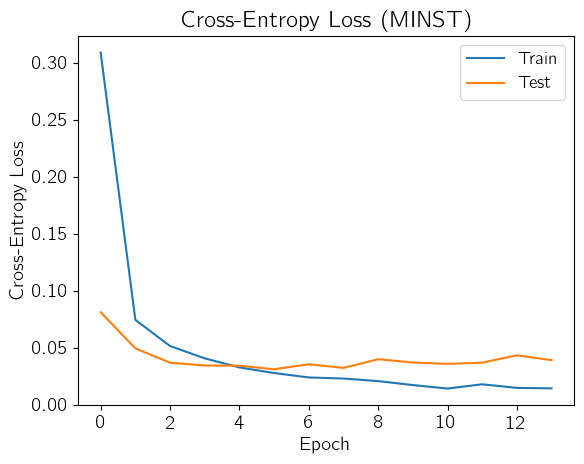

In [29]:
plot_train_val(train_loss, val_loss, "Cross-Entropy Loss (MINST)","Cross-Entropy Loss")

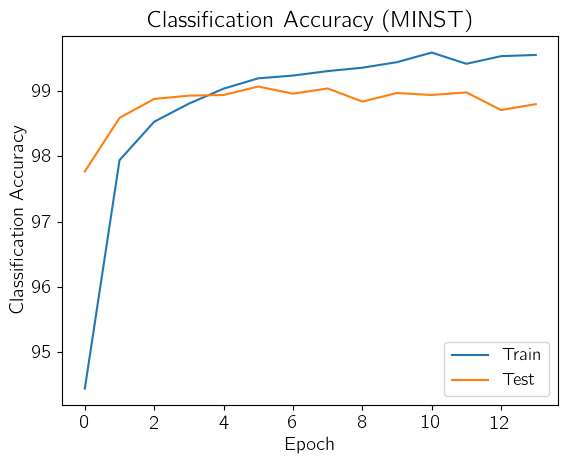

In [30]:
plot_train_val(train_acc, val_acc, "Classification Accuracy (MINST)","Classification Accuracy")

In [31]:
# Load Saved MINST 
model = MNIST_models(img_channel, img_w, n_classes)
model.load_state_dict(torch.load("MINST_classify_mdl.pt"))
test(test_minst_loader, model, torch.device("cpu"))

Eval 9880 / 10000 correct (98.80)


(0.039253386274678635, 98.80000305175781)